In [3]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

2025-07-26 01:38:38.558093: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-07-26 01:38:38.558118: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPHOCHS = 50

## Load the dataset


In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    )

Found 2152 files belonging to 3 classes.


2025-07-26 01:38:39.988658: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2025-07-26 01:38:39.994105: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-07-26 01:38:39.994246: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3050 Laptop GPU computeCapability: 8.6
coreClock: 1.5GHz coreCount: 16 deviceMemorySize: 3.81GiB deviceMemoryBandwidth: 178.84GiB/s
2025-07-26 01:38:39.994319: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-07-26 01:38:39.994367: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dyna

In [6]:
classnames = dataset.class_names
classnames

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [7]:
len(dataset)

68

In [8]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 0 1 1 0 0 1 0 0 1 1 1 0 1 2 0 1 1 0 0 1 0 1 1 1 0 0 1 1 1 0 1]


2025-07-26 01:38:40.063299: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2025-07-26 01:38:40.064101: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2688000000 Hz


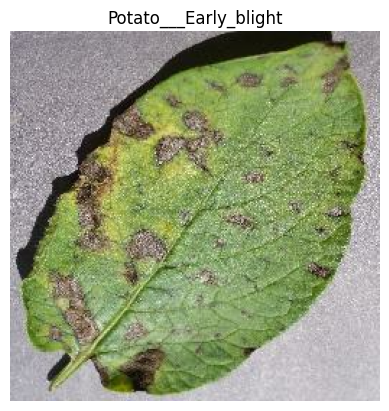

In [9]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.axis("off")
    plt.title(classnames[label_batch[0]])

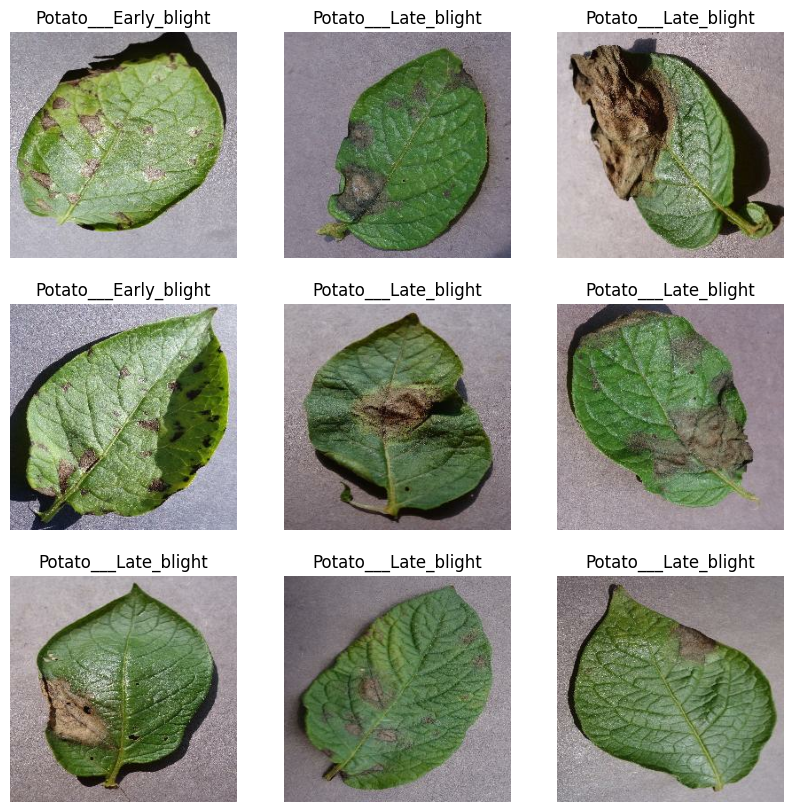

In [10]:
for image_batch, label_batch in dataset.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(classnames[label_batch[i]])
        plt.axis("off")
    plt.show()

In [11]:
train_size = 0.8
val_size = 0.1
test_size = 0.1
len(dataset) * train_size

54.400000000000006

In [12]:
train_ds = dataset.take(int(len(dataset) * train_size))
test_ds = dataset.skip(int(len(dataset) * train_size))   

In [13]:
def get_dataset_partitions(ds, train_size=0.8, val_size=0.1, test_size=0.1, shuffle=True, shuffle_size=10000):
    total_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=42)

    train_size = int(total_size * train_size)
    val_size = int(total_size * val_size)
    
    train_ds = dataset.take(train_size)
    val_ds = dataset.skip(train_size).take(val_size)
    test_ds = dataset.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions(dataset)

In [15]:
len(train_ds), len(val_ds), len(test_ds)

(54, 6, 8)

## Preprocessing the dataset

In [16]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
data_argmentation = tf.keras.Sequential([
    # pre-processing pipeline
    layers.experimental.preprocessing.Rescaling(1.0/255, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

## Training the Model

In [18]:
n_classes = len(classnames) # 3

model = models.Sequential([
    data_argmentation,
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    # Replace Flatten with GAP to reduce overfitting
    layers.GlobalAveragePooling2D(),
    
    # Dense Layers
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    
    # Output Layer
    layers.Dense(n_classes, activation='softmax')

])

model.build((BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)       

In [20]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [21]:
history = model.fit(
    train_ds,
    epochs=EPHOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50


2025-07-26 01:38:43.122472: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 268435456 exceeds 10% of free system memory.


 1/54 [..............................] - ETA: 2:08 - loss: 1.0589 - accuracy: 0.4375

2025-07-26 01:38:43.856706: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 268435456 exceeds 10% of free system memory.
2025-07-26 01:38:44.067430: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 268435456 exceeds 10% of free system memory.


 2/54 [>.............................] - ETA: 48s - loss: 0.8275 - accuracy: 0.6250 

2025-07-26 01:38:44.782962: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 268435456 exceeds 10% of free system memory.
2025-07-26 01:38:45.001959: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 268435456 exceeds 10% of free system memory.


54/54 [==============================] - 49s 887ms/step - loss: 0.2276 - accuracy: 0.9265 - val_loss: 2.4699 - val_accuracy: 0.4688
Epoch 2/50
54/54 [==============================] - 46s 861ms/step - loss: 0.1295 - accuracy: 0.9543 - val_loss: 2.4063 - val_accuracy: 0.4688
Epoch 3/50
54/54 [==============================] - 52s 970ms/step - loss: 0.0918 - accuracy: 0.9676 - val_loss: 3.4580 - val_accuracy: 0.4688
Epoch 4/50
54/54 [==============================] - 56s 1s/step - loss: 0.1060 - accuracy: 0.9688 - val_loss: 5.6579 - val_accuracy: 0.4688
Epoch 5/50
54/54 [==============================] - 55s 1s/step - loss: 0.0739 - accuracy: 0.9780 - val_loss: 3.4750 - val_accuracy: 0.4688
Epoch 6/50
54/54 [==============================] - 56s 1s/step - loss: 0.0797 - accuracy: 0.9722 - val_loss: 3.8918 - val_accuracy: 0.4792
Epoch 7/50
54/54 [==============================] - 55s 1s/step - loss: 0.0704 - accuracy: 0.9734 - val_loss: 1.8679 - val_accuracy: 0.6615
Epoch 8/50
54/54 [====

In [22]:
scores = model.evaluate(test_ds, verbose=1)

8/8 [==============================] - 2s 188ms/step - loss: 0.0823 - accuracy: 0.9828


In [23]:
scores

[0.0822879746556282, 0.982758641242981]

In [24]:
history

In [25]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [26]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']  

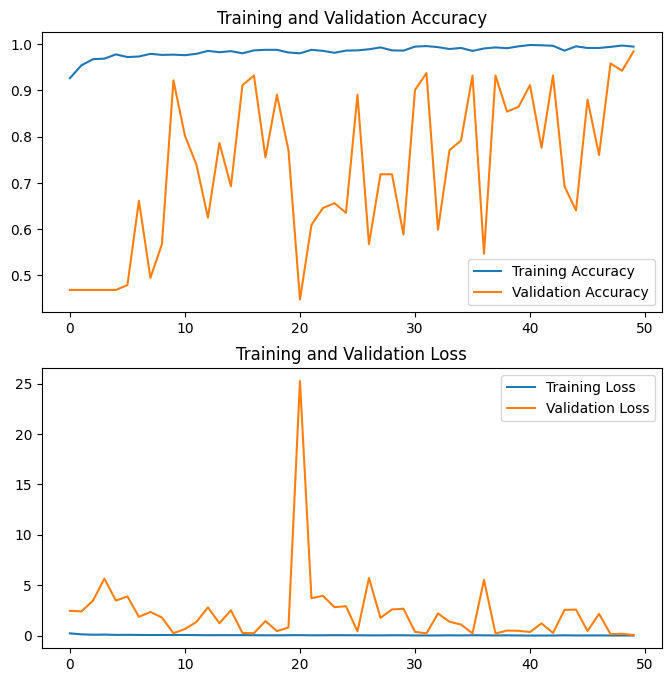

In [27]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()  

First image label: Potato___Late_blight
Predicted label: Potato___Late_blight


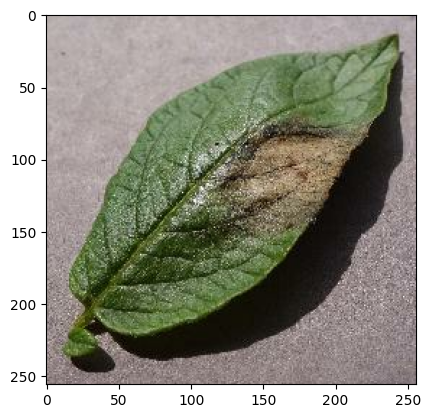

In [28]:
for image_batch, label_batch in test_ds.take(1):
    
    first_image = image_batch[0].numpy().astype("uint8")
    first_label = label_batch[0].numpy()

    print(f"First image label: {classnames[first_label]}")
    plt.imshow(first_image)

    batch_prediction = model.predict(image_batch)
    print(f"Predicted label: {classnames[batch_prediction[0].argmax()]}")


In [29]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch

    predictions = model.predict(img_array)

    predicted_label = classnames[predictions[0].argmax()]
    condifidence = round(100* predictions[0].max(), 2)
    return predicted_label, condifidence

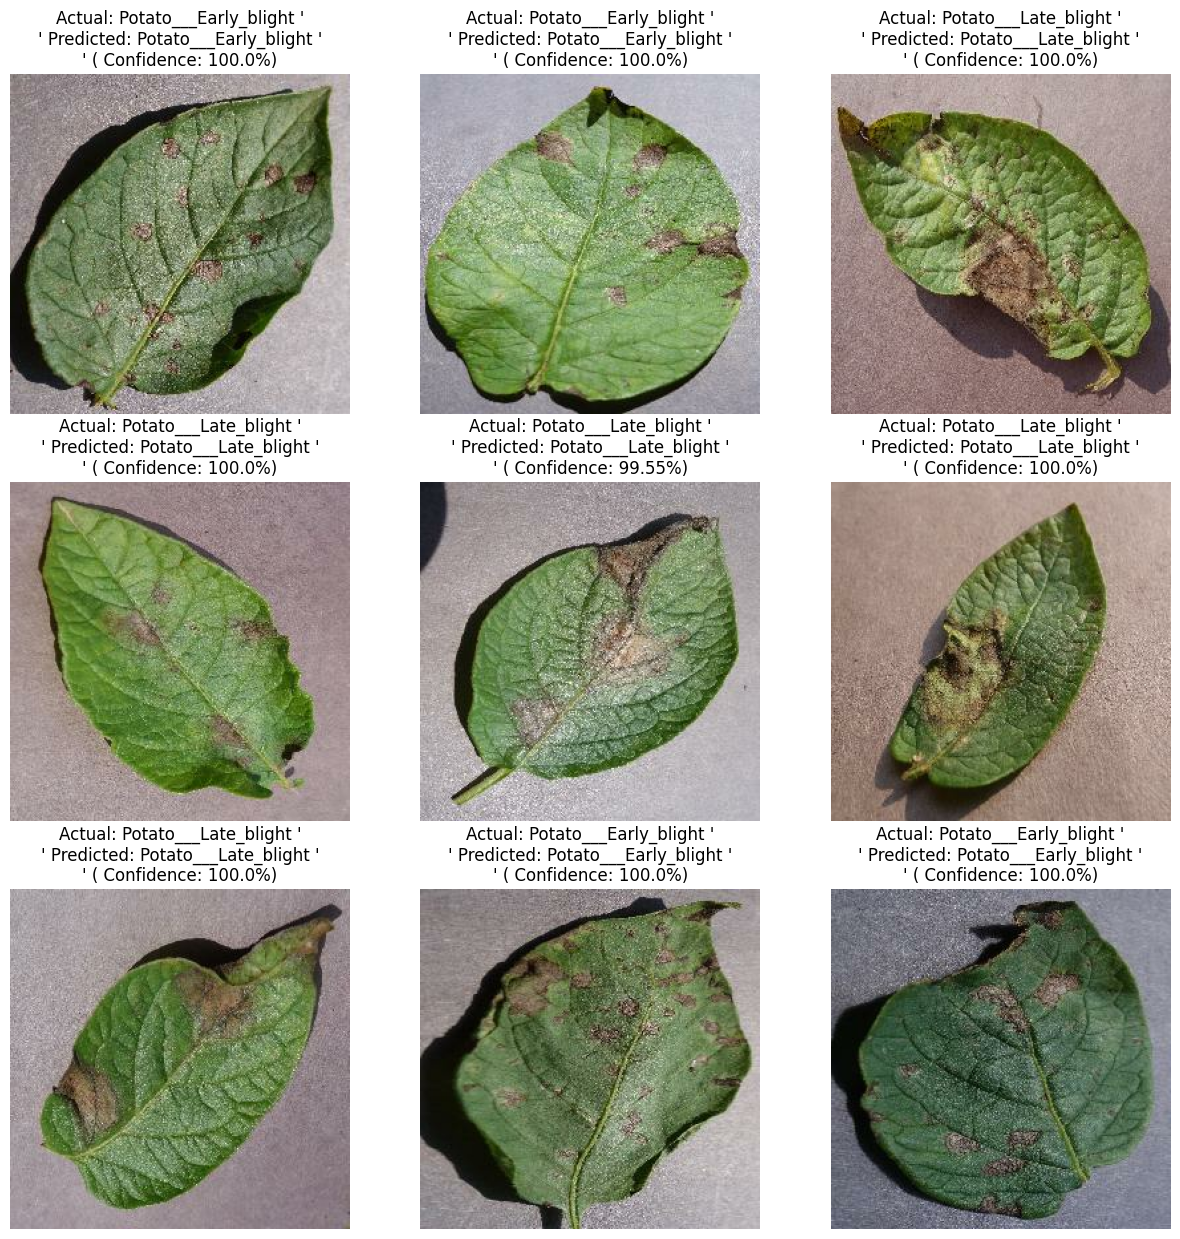

In [30]:
plt.figure(figsize=(15, 15))
for image_batch, label_batch in test_ds.take(1):
    for i in range(min(9, len(image_batch))):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))

        predicted_label, confidence = predict(model, image_batch[i].numpy())
        actual_label = classnames[label_batch[i].numpy()]
        plt.title(f"Actual: {actual_label} '\n' Predicted: {predicted_label} '\n' ( Confidence: {confidence}%)")
        plt.axis("off")
    plt.show()

In [31]:
model_version = 2

model.save(f"../saved_models/{model_version}")

2025-07-26 02:26:43.730896: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../saved_models/2/assets
